In [2]:
import pandas as pd
import numpy as np
import pyarrow
import seaborn as sns
import statsmodels.api as sm
from pysal.model import spreg
from pysal.lib import weights
from scipy import stats
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import osmnx as ox
import libpysal

/opt/homebrew/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/opt/homebrew/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/opt/homebrew/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:199: Numb

In [3]:
# get electric vehicle data
ev_df = pd.read_parquet('data/Cleaned data/all_vehicles_electric__df.parquet', engine='pyarrow')

In [4]:
# replace rows with value 'Male' with 1 and rows with value 'Female' with 2 in column 'gender' 
ev_df['sex'] = ev_df['sex'].replace({'Male': 1, 'Female': 2})


In [5]:
correlation_ev = ev_df.corr()
correlation_ev

,Year,gdhi,sex,age,population,Average variable unit price (£/kWh),ULSP: Pump price (p/litre),ULSD: Pump price (p/litre),Number of vehicles,Sum of Chargepoints,NQF level 4 or above,NQF level 3 or above,NQF level 2 or above
Year,1.000000e+00,3.184606e-01,-4.810378e-14,1.159197e-14,0.039926,9.102561e-01,-4.238969e-01,-3.564317e-01,3.042998e-01,1.868293e-01,7.556595e-01,6.080605e-01,5.875436e-01
gdhi,3.184606e-01,1.000000e+00,-1.382334e-14,3.756270e-15,0.130305,2.674236e-01,-1.451695e-01,-1.238230e-01,1.507569e-01,1.483206e-01,2.983695e-01,2.675472e-01,3.036558e-01
sex,-4.810378e-14,-1.382334e-14,1.000000e+00,6.098623e-18,0.024957,-3.529935e-14,1.774770e-14,1.672823e-14,-1.147901e-14,-6.529134e-15,-2.973612e-14,-2.616929e-14,-2.395715e-14
age,1.159197e-14,3.756270e-15,6.098623e-18,1.000000e+00,-0.268569,8.806803e-15,-1.749118e-14,-1.728291e-14,4.076337e-15,2.256025e-15,9.079911e-15,7.024877e-15,4.483674e-15
population,3.992629e-02,1.303045e-01,2.495742e-02,-2.685688e-01,1.000000,-2.040963e-02,-1.615444e-02,-1.355193e-02,7.415023e-02,9.244502e-02,3.725469e-02,4.472872e-02,1.512853e-01
Average variable unit price (£/kWh),9.102561e-01,2.674236e-01,-3.529935e-14,8.806803e-15,-0.020410,1.000000e+00,-2.251910e-01,-1.443901e-01,2.954297e-01,1.768360e-01,6.227483e-01,4.361128e-01,4.225021e-01
ULSP: Pump price (p/litre),-4.238969e-01,-1.451695e-01,1.774770e-14,-1.749118e-14,-0.016154,-2.251910e-01,1.000000e+00,9.939216e-01,-1.228539e-01,-9.094567e-02,-3.975702e-01,-3.711635e-01,-2.306123e-01
ULSD: Pump price (p/litre),-3.564317e-01,-1.238230e-01,1.672823e-14,-1.728291e-14,-0.013552,-1.443901e-01,9.939216e-01,1.000000e+00,-9.879296e-02,-7.389122e-02,-3.432929e-01,-3.352696e-01,-1.861475e-01
Number of vehicles,3.042998e-01,1.507569e-01,-1.147901e-14,4.076337e-15,0.074150,2.954297e-01,-1.228539e-01,-9.879296e-02,1.000000e+00,8.046930e-02,2.505983e-01,1.751995e-01,1.956745e-01
Sum of Chargepoints,1.868293e-01,1.483206e-01,-6.529134e-15,2.256025e-15,0.092445,1.768360e-01,-9.094567e-02,-7.389122e-02,8.046930e-02,1.000000e+00,1.621260e-01,1.189502e-01,1.182845e-01


<AxesSubplot: >

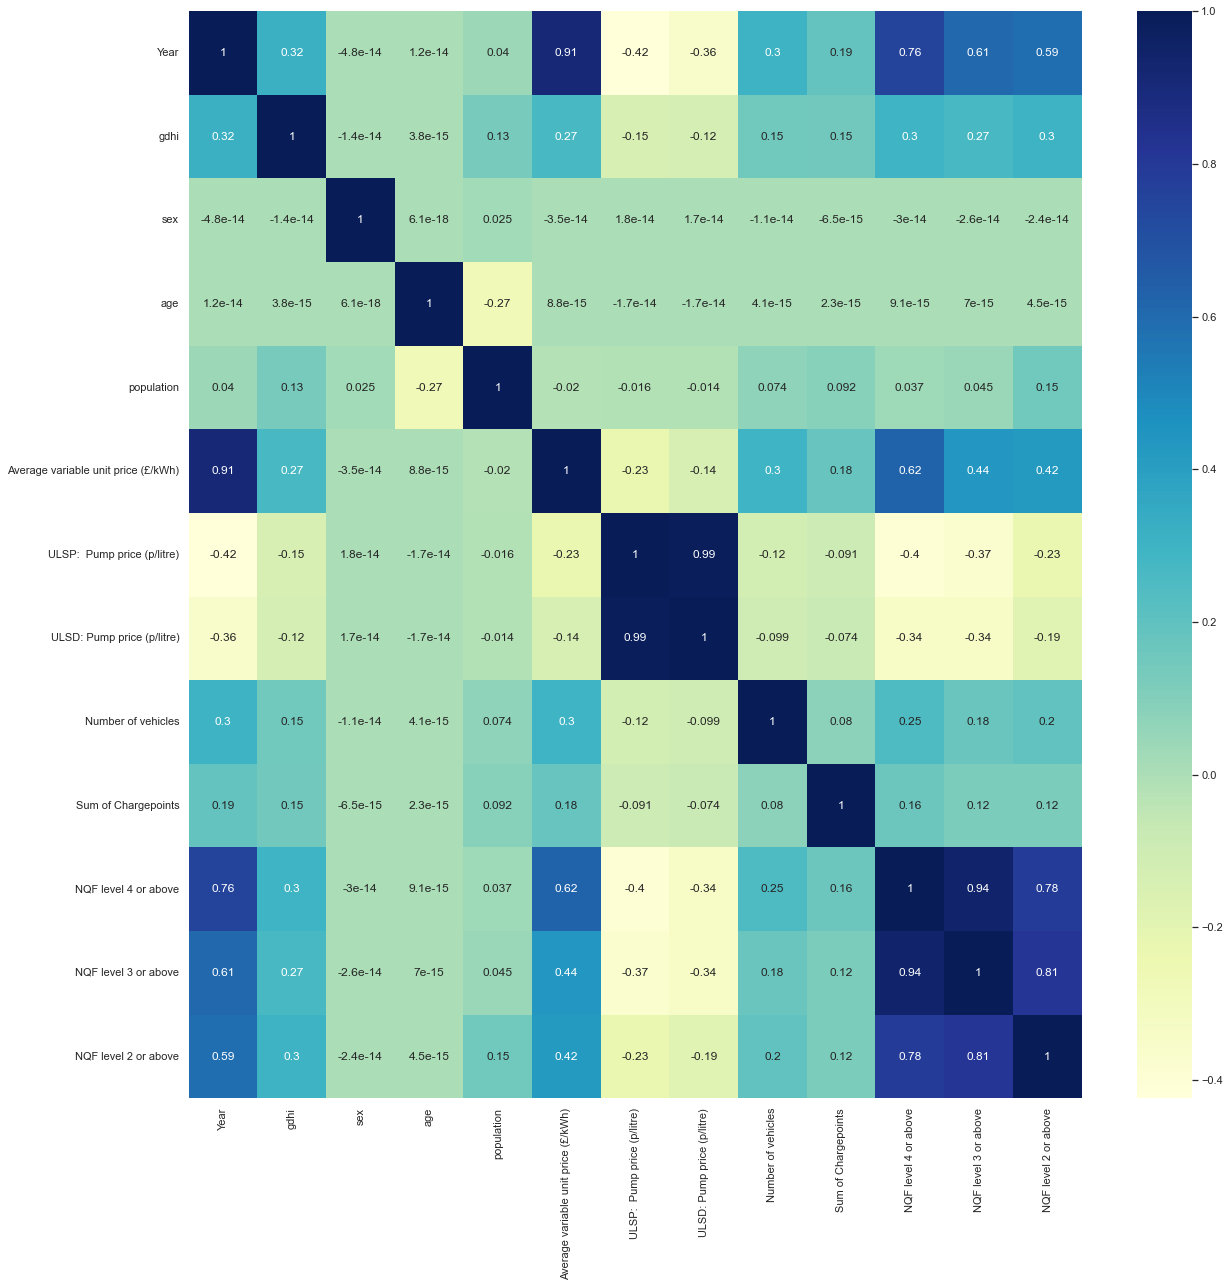

In [6]:
# make it bigger
sns.set(rc={'figure.figsize':(20,20)})
# make a heatmap and make it pretty
sns.heatmap(correlation_ev, cmap="YlGnBu", annot=True)


In [7]:
ev_df.shape

(752024, 19)

In [8]:
# drop age column
ev_df = ev_df.drop(columns=['age','sex','BodyType','Fuel','Keepership'])
# strip spaces from column names
ev_df.columns = ev_df.columns.str.strip()
# aggregate and mean of the values 'population' and 'Number of vehicles'
ev_df = ev_df.groupby(['ITL level 3','Year', 'gdhi','ITL level 1', 'ITL level 2','Average variable unit price (£/kWh)',
                    'ULSP:  Pump price (p/litre)', 'ULSD: Pump price (p/litre)',
                    'Sum of Chargepoints', 'NQF level 4 or above',
                    'NQF level 3 or above', 'NQF level 2 or above']).mean()
# drop rows with duplicate values
ev_df = ev_df.drop_duplicates()
# reset index
ev_df = ev_df.reset_index()
ev_df.shape

(1947, 14)

<AxesSubplot: >

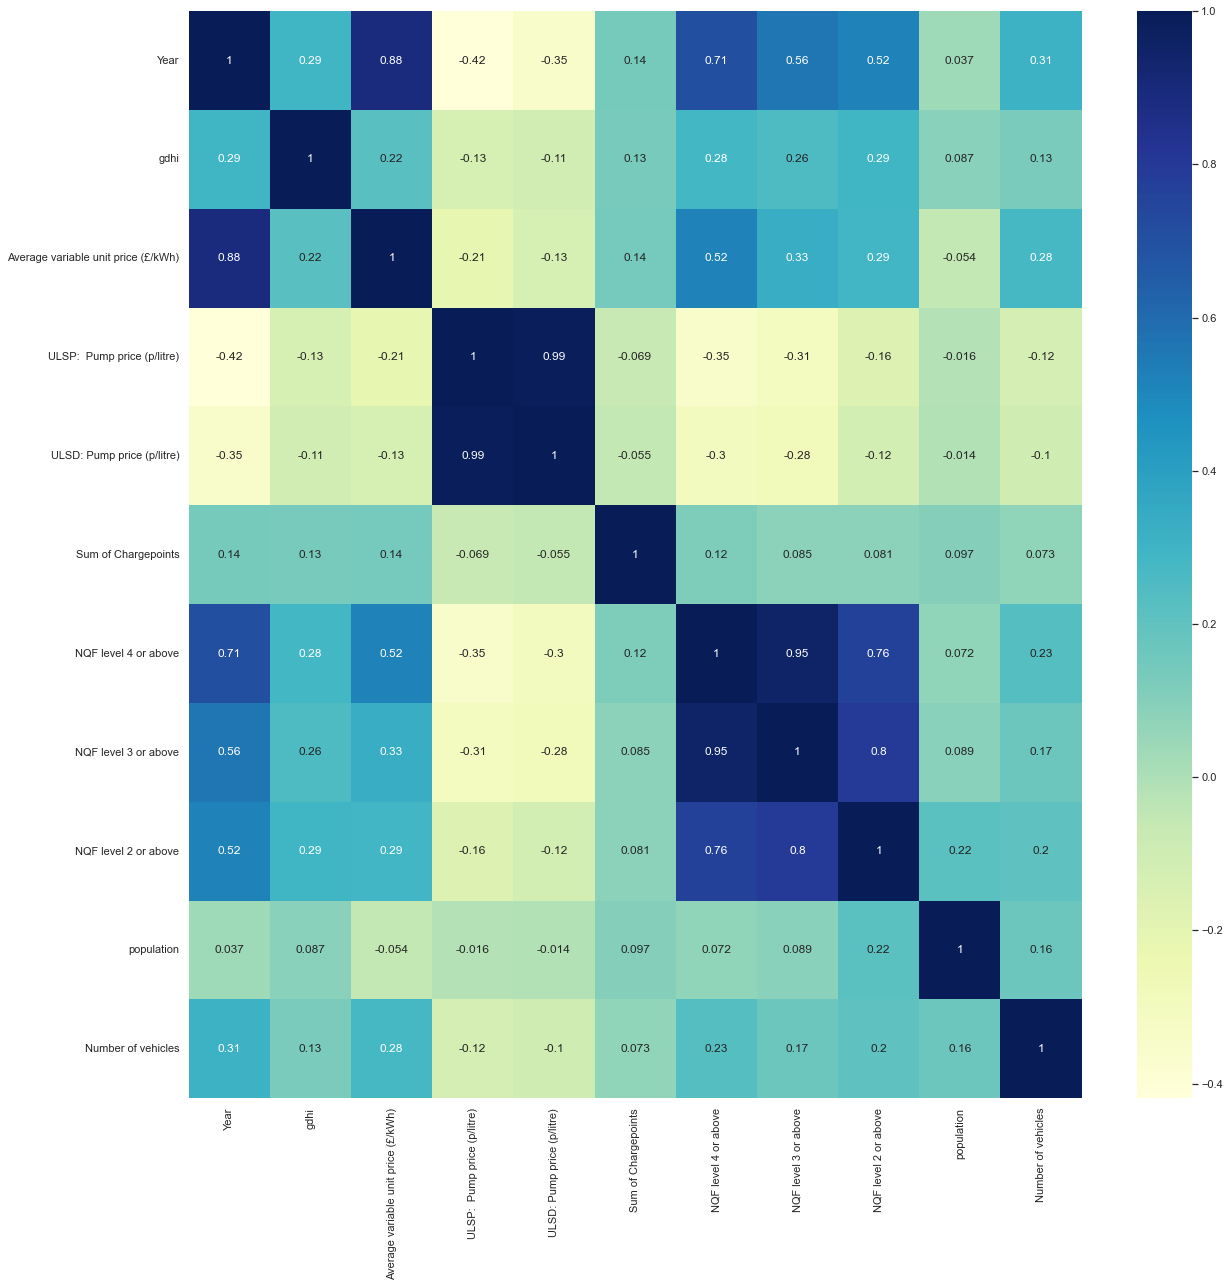

In [9]:
# check correlation heatmap again
correlation_ev = ev_df.corr()
sns.heatmap(correlation_ev, cmap="YlGnBu", annot=True)

In [10]:
# try all the below models

# ARIMA model, Winters' method
# can't use these because they have no spatial component

# SSA model (Singular Spectrum Analysis) with SVAR (Spatial Vector Autoregression)

# VARMAX (Vector Autoregression Moving Average with eXogenous regressors)

# SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors)
# can't use this because no spatial component

# TBATS (Exponential smoothing state space model with Box-Cox transformation, ARMA errors, Trend and Seasonal components)

# Artificial Neural Network (ANN)

# LSTM (Long Short Term Memory)

# Prophet (Facebook's forecasting tool)

# seq2seq (Sequence to Sequence learning with Neural Networks)

In [11]:
# replace Caithness and Sutherland and Ross and Cromarty with "Caithness, Scotland" in ITL level 3
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["Caithness and Sutherland and Ross and Cromarty"], "Caithness, Scotland")
# replace Clackmannanshire and Fife with "Clackmannanshire, Scotland" in ITL level 3
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["Clackmannanshire and Fife"], "Clackmannanshire, Scotland")
# replace East Ayrshire and North Ayrshire mainland with East Ayrshire
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["East Ayrshire and North Ayrshire mainland"], "East Ayrshire")
# replace East Dunbartonshire and West Dunbartonshire and Helensburgh and Lomond with East Dunbartonshire
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["East Dunbartonshire, West Dunbartonshire and Helensburgh and Lomond"], "East Dunbartonshire")
# replace East Lothian and Midlothian with East Lothian
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["East Lothian and Midlothian"], "East Lothian")
# replace Inverclyde, East Renfrewshire and Renfrewshire with Inverclyde
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["Inverclyde, East Renfrewshire and Renfrewshire"], "Inverclyde")
# replace Inverness and Nairn and Moray, Badenoch and Strathspey with Inverness
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["Inverness and Nairn and Moray, Badenoch and Strathspey"], "Inverness")
# replace Lochaber, Skye and Lochalsh, Arran and Cumbrae and Argyll and Bute with Lochaber
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["Lochaber, Skye and Lochalsh, Arran and Cumbrae and Argyll and Bute"], "Lochaber")
# replace Armagh City, Banbridge and Craigavon with Armagh City
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["Armagh City, Banbridge and Craigavon"], "Armagh City")
# replace Lisburn and Castlereagh with Lisburn
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["Lisburn and Castlereagh"], "Lisburn")
# replace Mid and East Antrim with Mid Antrim
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["Mid and East Antrim"], "Mid Antrim")
# replace Harrow and Hillingdon with Harrow
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["Harrow and Hillingdon"], "Harrow")
# replace Merton, Kingston upon Thames and Sutton with Merton
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["Merton, Kingston upon Thames and Sutton"], "Merton")
# replace Redbridge and Waltham Forest with Waltham Forest
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["Redbridge and Waltham Forest"], "Waltham Forest")
# replace Barnsley, Doncaster and Rotherham with Barnsley
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["Barnsley, Doncaster and Rotherham"], "Barnsley")
# replace Bath and North East Somerset, North Somerset and South Gloucestershire with North East Somerset
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["Bath and North East Somerset, North Somerset and South Gloucestershire"], "North East Somerset")
# replace Bristol, City of with Bristol
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["Bristol, City of"], "Bristol")
# replace Cornwall and Isles of Scilly with Cornwall
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["Cornwall and Isles of Scilly"], "Cornwall")
# replace Breckland and South Norfolk with Breckland
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["Breckland and South Norfolk"], "Breckland")
# replace Essex Haven Gateway with Essex
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["Essex Haven Gateway"], "Essex")
# replace Essex Thames Gateway with Thames Gateway
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["Essex Thames Gateway"], "Thames Gateway")
# replace North and West Norfolk with North Norfolk
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["North and West Norfolk"], "North Norfolk")
# replace Norwich and East Norfolk with Norwich
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["Norwich and East Norfolk"], "Norwich")
# replace Kent Thames Gateway with Kent
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["Kent Thames Gateway"], "Kent")
# replace Chorley and West Lancashire with Chorley
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["Chorley and West Lancashire"], "Chorley")
# replace Conwy and Denbighshire with Conwy
ev_df["ITL level 3"] = ev_df["ITL level 3"].replace(["Conwy and Denbighshire"], "Conwy")


In [12]:
import time
from geopy.geocoders import Nominatim

def get_latitude_longitude(place_name, max_retries=3):
    geolocator = Nominatim(user_agent="geoapiExercises")
    retries = 0

    while retries < max_retries:
        try:
            location = geolocator.geocode(place_name)
            if location:
                latitude = location.latitude
                longitude = location.longitude
                return latitude, longitude
            else:
                return None, None

        except Exception as e:
            retries += 1
            print(f"Attempt {retries} failed. Retrying...")
            time.sleep(1)  # Wait for 1 second before retrying

    print("Max retries exceeded. Could not fetch latitude and longitude.")
    return None, None

# create a new dataframe with ITL level 3 unique values
itl3_df = pd.DataFrame(ev_df["ITL level 3"].unique(), columns=["ITL level 3"])

# get latitude and longitude for all values in the dataframe
itl3_df["latitude"], itl3_df["longitude"] = zip(*itl3_df["ITL level 3"].apply(get_latitude_longitude))
# use the dataframe to create a dictionary for latitude and longitude
itl3_dict = itl3_df.set_index('ITL level 3').T.to_dict('list')

# add latitude and longitude to the original dataframe
ev_df["latitude"] = ev_df["ITL level 3"].map(lambda x: itl3_dict[x][0])
ev_df["longitude"] = ev_df["ITL level 3"].map(lambda x: itl3_dict[x][1])

ev_df.head()


In [ ]:
# Assuming you have already loaded your data into a pandas DataFrame named 'data'

# Define your dependent variable and explanatory variables
dependent_var = 'Number of vehicles'
explanatory_vars = ['gdhi', 'population', 'Average variable unit price (£/kWh)',
                    'ULSP:  Pump price (p/litre)', 'ULSD: Pump price (p/litre)',
                    'Sum of Chargepoints', 'NQF level 4 or above',
                    'NQF level 3 or above', 'NQF level 2 or above','latitude', 'longitude']

# Fit OLS regression model with spatial weight matrix
spatial_weights = libpysal.weights.KNN.from_array(ev_df[['latitude', 'longitude']].values, k=4)  # Adjust k as needed
model = spreg.OLS(ev_df[dependent_var].values, ev_df[explanatory_vars].values, w=spatial_weights)

# Print regression results
print(model.summary)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:        1947
Mean dependent var  :   1339.3814                Number of Variables   :          12
S.D. dependent var  :   4384.4904                Degrees of Freedom    :        1935
R-squared           :      0.1332
Adjusted R-squared  :      0.1283
Sum squared residual:32427265492.152                F-statistic           :     27.0269
Sigma-square        :16758276.740                Prob(F-statistic)     :   5.519e-53
S.E. of regression  :    4093.687                Log likelihood        :  -18950.246
Sigma-square ML     :16654989.981                Akaike info criterion :   37924.492
S.E of regression ML:   4081.0526                Schwarz criterion     :   37991.380

--------------------------------------------------------------------------

/opt/homebrew/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 177 disconnected components.
  warnings.warn(message)


In [ ]:
# get mse and rmse
from sklearn.metrics import mean_squared_error
from math import sqrt

# get predicted values
predicted = model.predy

# get actual values
actual = ev_df[dependent_var].values

# get mse
mse = mean_squared_error(actual, predicted)

# get rmse
rmse = sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 16654989.980560817
RMSE: 4081.052557926793


This is the output of a multiple linear regression analysis.

- R-squared (R²): R-squared measures the proportion of the variance in the dependent variable that is predictable from the independent variables. In this case, the R-squared value is 0.1332, indicating that approximately 13.32% of the variance in the dependent variable (dep_var) can be explained by the independent variables (var_1 to var_11).

- Adjusted R-squared: This is a modified version of R-squared that accounts for the number of independent variables and the sample size. It penalizes the addition of irrelevant variables to the model. The adjusted R-squared value is 0.1283.

- F-statistic: The F-statistic tests the overall significance of the regression model. It evaluates whether the overall regression model is statistically significant. The F-statistic value is 27.0269, and the associated probability (Prob(F-statistic)) is very low (5.519e-53), indicating that the overall model is statistically significant.

- Coefficients: The coefficients represent the estimated effect of each independent variable on the dependent variable. For example, var_2 has a coefficient of 0.5420, suggesting that a one-unit increase in var_2 is associated with an estimated increase of 0.5420 units in the dependent variable.

- Multicollinearity Condition Number: Multicollinearity condition number is a measure of multicollinearity among the independent variables. A condition number above 30 indicates possible multicollinearity issues. In this case, the condition number is 829.452, which may suggest the presence of multicollinearity.

- Tests on Normality of Errors: The Jarque-Bera test checks for normality of errors. A significant result (low probability) indicates that the errors are not normally distributed.

- Diagnostics for Heteroskedasticity: The Breusch-Pagan and Koenker-Bassett tests are used to detect heteroskedasticity in the errors. Significant results (low probabilities) suggest the presence of heteroskedasticity.

Overall, the model shows some explanatory power (R-squared), but there may be issues with multicollinearity and heteroskedasticity. It is essential to further investigate and address these issues to improve the model's validity and predictive accuracy.

In [ ]:
# Check for multicollinearity using correlation matrix
correlation_matrix = ev_df[explanatory_vars].corr()

# Visualize correlation matrix using heatmap
sns.heatmap(correlation_matrix, annot=True)

# If high correlation (>0.7) is found between variables, consider removing one of them or perform PCA for dimensionality reduction.


NameError: name 'ev_df' is not defined